Upload the used-cars CSV file from Kaggle


Saving car data.csv to car data (2).csv

 Data loaded successfully!


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


(301, 9)
Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')

Missing values per column:
Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64


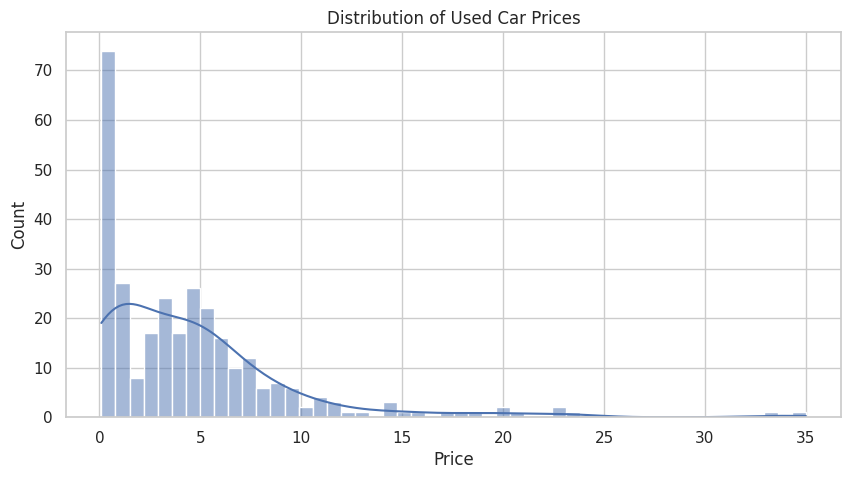

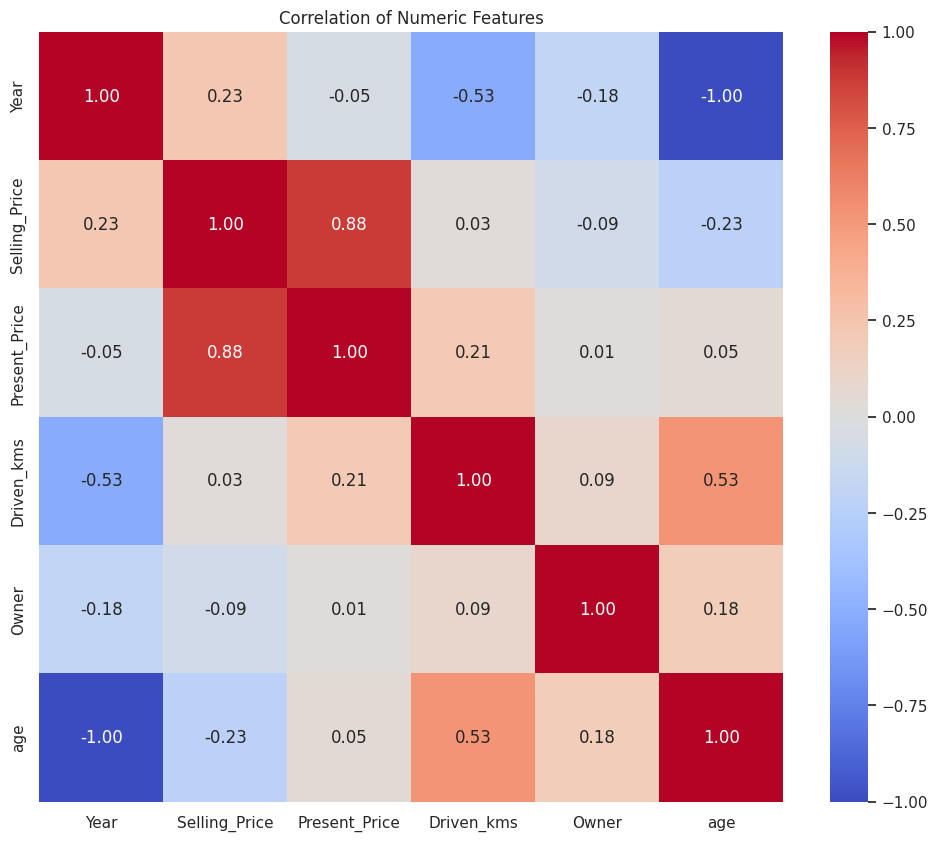

Categorical columns: ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']

Train shape: (239, 9) Test shape: (60, 9)

 Tuning RandomForest...
Best RandomForest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest MAE: 1.406, R2: 0.522

 Tuning XGBoost...
Best XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
XGBoost MAE: 1.043, R2: 0.789

 Tuning Ridge...
Best Ridge: {'alpha': 10.0}
Ridge MAE: 1.564, R2: 0.746

 Tuning Lasso...
Best Lasso: {'alpha': 0.1}
Lasso MAE: 1.613, R2: 0.739

📊 Model Comparison:


,MAE,R2
RandomForest,1.405681,0.521541
XGBoost,1.043200,0.788675
Ridge,1.563995,0.745638
Lasso,1.612924,0.739221


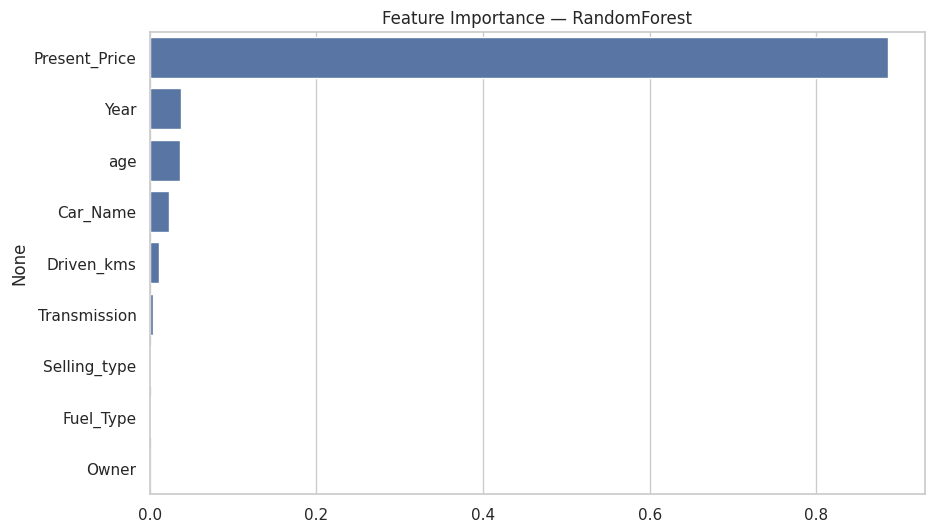

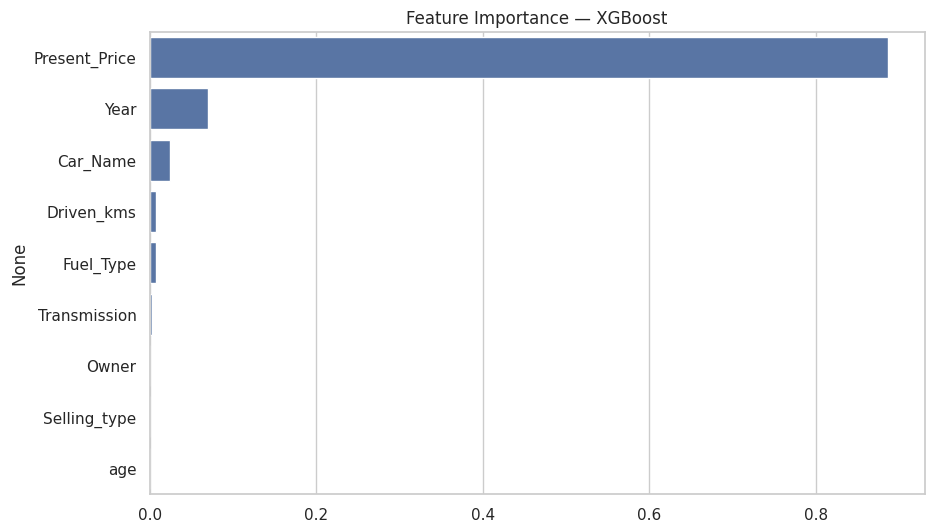


 Sample Prediction on Test Set
Input Features:


,Car_Name,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,age
94,71,2008,22.78,89000,2,0,0,0,17


Predicted Price: 8.95


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# =============================================================
#  TASK 3 — USED CAR PRICE PREDICTION (Kaggle Dataset)
# =============================================================

# 0. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Optional: install XGBoost
!pip install xgboost > /dev/null
from xgboost import XGBRegressor

# 1. UPLOAD DATASET
print("Upload the used-cars CSV file from Kaggle")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\n Data loaded successfully!")
display(df.head())
print(df.shape)
print(df.columns)

# 2. DATA CLEANING & FEATURE ENGINEERING

# Drop duplicates
df = df.drop_duplicates()

# Inspect nulls
print("\nMissing values per column:")
print(df.isnull().sum())

# The dataset likely has columns like: name, year, selling_price, km_driven, fuel_type, transmission, owner, engine, mileage etc.

# Clean / Convert numeric features stored as string:
# Example: Engine and Mileage may come as "1234 CC", "15 kmpl"
if "engine" in df.columns:
    df["engine_cc"] = df["engine"].str.extract(r'(\d+)').astype(float)
if "mileage" in df.columns:
    df["mileage_value"] = df["mileage"].str.extract(r'(\d+\.\d+|\d+)').astype(float)
if "power" in df.columns:
    df["power_value"] = df["power"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

# Age of car = current year (or a reference) - year of manufacture
df["age"] = 2025 - df["Year"]  # or use actual year

# Drop original columns that are less useful after feature extraction
cols_to_drop = ["engine", "mileage", "power"]
for c in cols_to_drop:
    if c in df.columns:
        df = df.drop(columns=c)

# Target variable: 'price' (assuming the dataset has a column “price” or “selling_price”)
if "Selling_Price" in df.columns: # Changed from selling_price to Selling_Price
    target = "Selling_Price"
elif "price" in df.columns:
    target = "price"
else:
    raise ValueError("Cannot find target column 'Selling_Price' or 'price' in dataset")

# 3. EXPLORATORY DATA ANALYSIS (EDA)

sns.set_theme(style="whitegrid")

# Price distribution
plt.figure(figsize=(10,5))
sns.histplot(df[target], kde=True, bins=50)
plt.title("Distribution of Used Car Prices")
plt.xlabel("Price")
plt.show()

# Correlation heatmap for numeric features
numeric_feats = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_feats].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Numeric Features")
plt.show()

# 4. ENCODING CATEGORICAL FEATURES
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 5. PREPARE TRAINING DATA
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# 6. MODEL TRAINING & HYPERPARAMETER TUNING

models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective="reg:squarederror"),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.01, 0.1]
    },
    "Ridge": {
        "alpha": [0.1, 1.0, 10.0]
    },
    "Lasso": {
        "alpha": [0.001, 0.01, 0.1]
    }
}

best_models = {}
for name, model in models.items():
    print(f"\n Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    best_models[name] = best
    print(f"Best {name}: {grid.best_params_}")
    preds = best.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} MAE: {mae:.3f}, R2: {r2:.3f}")

# 7. COMPARE RESULTS
results = {}
for name, model in best_models.items():
    preds = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

results_df = pd.DataFrame(results).T
print("\n📊 Model Comparison:")
display(results_df)

# 8. FEATURE IMPORTANCE (for tree-based models)
if "RandomForest" in best_models:
    rf = best_models["RandomForest"]
    feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature Importance — RandomForest")
    plt.show()

if "XGBoost" in best_models:
    xgb = best_models["XGBoost"]
    feat_imp_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp_xgb.values, y=feat_imp_xgb.index)
    plt.title("Feature Importance — XGBoost")
    plt.show()

# 9. SAMPLE PREDICTION
print("\n Sample Prediction on Test Set")
sample = X_test.sample(1, random_state=1)
pred_price = best_models["XGBoost"].predict(sample)[0]
print("Input Features:")
display(sample)
print(f"Predicted Price: {pred_price:.2f}")

# 10. SAVE MODEL (OPTIONAL)
import joblib
joblib.dump(best_models["XGBoost"], "used_car_price_model_xgb.pkl")
files.download("used_car_price_model_xgb.pkl")
